In [1]:
%load_ext autoreload
import os
os.chdir('/scratch/bva212/dl_project/code/')
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset, UnlabeledDataset_new
from helper import collate_fn, draw_box

import pickle
import time
import copy

In [2]:
%autoreload 2

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file

image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [5]:
random.seed(1008)
random.shuffle(unlabeled_scene_index)
train_idx = unlabeled_scene_index[:84]
val_idx = unlabeled_scene_index[84:95]
test_idx = unlabeled_scene_index[95:]

In [6]:
transform = torchvision.transforms.ToTensor()
bs = 4
datasets = {phase: UnlabeledDataset_new(image_folder=image_folder, 
                                      scene_index=unlabeled_scene_index, 
                                   ) for phase, indices in zip (['train', 'val', 'test'],
                                                      [train_idx, val_idx, test_idx]
                                                     )}

In [7]:
dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase], 
                                                  batch_size=32, 
                                                  shuffle=True, 
                                                  num_workers=4, 
#                                                   collate_fn=collate_fn
                                                 ) for phase in ['train', 'val', 'test']}

In [35]:
sample = datasets['train'].__getitem__(0)[0]

### Original

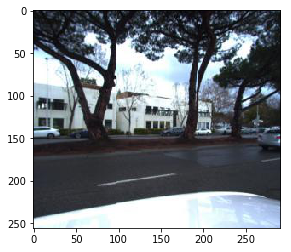

In [36]:
plt.imshow(torch.cat(torch.chunk(sample, 3, 0), 3).squeeze(0).permute(1,2,0).numpy().astype(np.uint8))

### Jigsawed

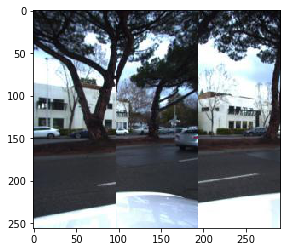

In [28]:
plt.imshow(torch.cat(torch.chunk(sample, 3, 0), 3).squeeze(0).permute(1,2,0).numpy().astype(np.uint8))

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        feature_extractor = torchvision.models.resnet50(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Linear(196608, 6)

        
    def forward(self, inputs):
        N, jigsaw_slices, C, H, W = inputs.shape
        
        out = []
        for i in range(jigsaw_slices):
            out.append(self.feature_extractor(inputs[:, i, :]))
        
        out = torch.cat(out,1)
        out = self.classifier(out.view(N, -1))
        return out

In [9]:
model = Model()

In [10]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def train_model(model, dataloader, criterion, optimizer, scheduler,
                num_epochs = 10,verbose = True, print_every = 1):

    start_time = time.time()

    best_model_wts = best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc_dict = {'train':[],'validation':[]}
    loss_dict = {'train':[],'validation':[]}

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        if verbose:
            if epoch % print_every == 0:
                print(f'Epoch {epoch+1}/{num_epochs}')
                print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            running_total = 0

            for iter_, data in enumerate(dataloader[phase]):

                inputs = data[0]
                labels = data[1]

                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.LongTensor).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_corrects += torch.sum(preds == labels).item()
                running_loss += loss.item() * inputs.size()[0]
                running_total += inputs.shape[0]

                if iter_ % 100:
                    print(f'{phase} Iteration: {iter_+1}/{len(dataloader[phase])} loss: {running_loss/running_total} Acc: {running_corrects/running_total}', end="\r")

            epoch_loss = running_loss / running_total
            epoch_acc = running_corrects / running_total

            if verbose:
                if epoch % print_every == 0:
                    print()
                    print(f'{phase} Loss: {epoch_loss:.4f} {phase} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                loss_dict['train'].append(epoch_loss)
                acc_dict['train'].append(epoch_acc)
            else:
                loss_dict['validation'].append(epoch_loss)
                acc_dict['train'].append(epoch_acc)
                if scheduler:
                    scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                if os.path.exists('/scratch/bva212/dl_project/jigsaw_best_model'):
                    os.remove('/scratch/bva212/dl_project/jigsaw_best_model')
                torch.save(best_model_wts, '/scratch/bva212/dl_project/jigsaw_best_model')
                print(f'Successfully updated best model after {epoch+1} epochs')
        
        if epoch % print_every == 0:
            print('')

    time_elapsed = time.time() - start_time
    print(f'Training time: {int(time_elapsed / 60)}minutes {time_elapsed % 60}s')
    print(f'Best val Threat Score: {best_acc:4f}')

    for i, phase in enumerate(['train']):

        fig = plt.figure()
        plt.plot(loss_dict[phase])
        plt.title('Loss per epoch for ' + phase)
        plt.legend()
        plt.show()

        fig = plt.figure()
        plt.plot(acc_dict[phase])
        plt.title('Accuracy per epoch for ' + phase)
        plt.legend()
        plt.show()

    # model.load_state_dict(best_model_wts)

    return model, best_model_wts

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='sum')

In [12]:
model, best_model_wts = train_model(model.cuda(), dataloaders, criterion, optimizer, None,3)

Epoch 1/3
----------
Successfully saved checkpoint model after 1 epochs and 1 iterations
Successfully saved checkpoint model after 1 epochs and 1001 iterations76425
train Iteration: 1985/1985 loss: 28.080501745978 Acc: 0.9189027462836986065
train Loss: 28.0805 train Acc: 0.9189
Successfully saved checkpoint model after 1 epochs and 1 iterations
val Iteration: 260/260 loss: 4.385200934894042 Acc: 0.97835497835497831
val Loss: 4.3852 val Acc: 0.9784
Successfully updated best model after 1 epochs

Epoch 2/3
----------
Successfully saved checkpoint model after 2 epochs and 1 iterations
Successfully saved checkpoint model after 2 epochs and 1001 iterations22578
val Iteration: 260/260 loss: 0.6700234236540618 Acc: 0.99362674362674360527
val Loss: 0.6700 val Acc: 0.9936
Successfully updated best model after 2 epochs

Epoch 3/3
----------
Successfully saved checkpoint model after 3 epochs and 1 iterations


KeyboardInterrupt: 